# Projet FixMatch


## I. Importing libraries and setup

First, we import the libraries we will use in the notebook:

In [2]:
from torchvision.transforms import RandAugment

In [6]:
# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# vizualisation
import torchsummary

# transforms
import torchvision.transforms as T
import kornia.augmentation as K
from torchvision.transforms import RandAugment

# metrics
from torchmetrics import Accuracy

# torchvision
import torchvision
import torchvision.transforms as transforms

# plotting
import matplotlib.pyplot as plt
from torchview import draw_graph

from IPython.display import display
from IPython.core.display import SVG, HTML

from tqdm import tqdm

# typing
from typing import Callable

from utils import plot_images, plot_transform
from model import ConvNN, display_model

%load_ext autoreload
%autoreload 2

Then, we setup the device:

In [7]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cpu


/home/europe/miniconda3/envs/pytorch-tabular/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
torch.cuda.is_available()

False

We initialize global variables, according to the values in the paper, used in the fixmatch algorithm:

In [3]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.95 #! 0.95 in the paper
LAMBDA_U = 1
MU = 7
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.001

Finally, we download the dataset:

In [4]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True,
    transform=T.ToTensor()
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=T.ToTensor()
)
                                        
trainloader = DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
                                       
testloader = DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:08<00:00, 19369797.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## II. Convolutional Neural Network on 100% dataset

In [6]:
EPOCHS = 4
SUBSET_PROP = 1.00
trainset_subsample, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])
trainloader_subsample = DataLoader(
    trainset_subsample,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
model = ConvNN().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA)
scheduler = None
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss().to(device)
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
accuracy_test = Accuracy(task="multiclass", num_classes=10).to(device)

for epoch in range(EPOCHS):
    # Training
    model.train()
    epoch_loss = 0.0
    for (images, labels) in (pbar := tqdm(trainloader_subsample, desc=f"Epoch {epoch: >5}")) :
        # extract mini batch
        images, labels = images.to(device), labels.to(device)
        batch_size = images.size(0)
        # forward pass
        outputs = model.forward(images)
        label_pred = outputs.argmax(dim=1)
        loss = criterion.forward(outputs, labels)
        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()
        
        # update metrics
        epoch_loss += loss.item()*batch_size/len(trainloader)
        current_lr = optimizer.param_groups[0]['lr']
        train_accuracy = accuracy(labels.cpu(), label_pred.cpu())
        # print statistics
        pbar.set_postfix(
            {
                "train_loss": f"{loss.item():.2f}",
                "train_epoch_loss": f"{epoch_loss:.2f}",
                "train_accuracy": f"{train_accuracy:.2f}",
                "lr": f"{current_lr:.3f}",
            }
        )
    if scheduler is not None:
        scheduler.step()

    # Validation
    with torch.no_grad():
        model.eval()
        test_epoch_loss = 0.0
        for (images_test, label_test) in (pbar := tqdm(testloader, desc=f"Epoch test {epoch: >1}")):
            images_test, label_test = images_test.to(device), label_test.to(device)
            outputs_val = model.forward(images_test)
            label_pred_test = outputs_val.argmax(dim=1)
            loss_test = criterion.forward(outputs_val, label_test)
            test_epoch_loss += loss_test.item()*images_test.size(0)/len(testloader)
            test_accuracy = accuracy_test(label_test.cpu(), label_pred_test.cpu())
            pbar.set_postfix(
                {
                    "test_loss": f"{loss_test.item():.2f}",
                    "test_epoch_loss": f"{test_epoch_loss:.2f}",
                    "test_accuracy": f"{test_accuracy:.2f}",
                }
            )


test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

print(f"Test score with {SUBSET_PROP}: {test_accuracy}")

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with {SUBSET_PROP} - {test_accuracy*100:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}.png")

/home/europe/miniconda3/envs/fixmatch2/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Epoch test 3: 100%|██████████| 157/157 [00:00<00:00, 222.10it/s, test_loss=1.96, test_epoch_loss=121.30, test_accuracy=0.25]


Test score with 0.1: 0.25


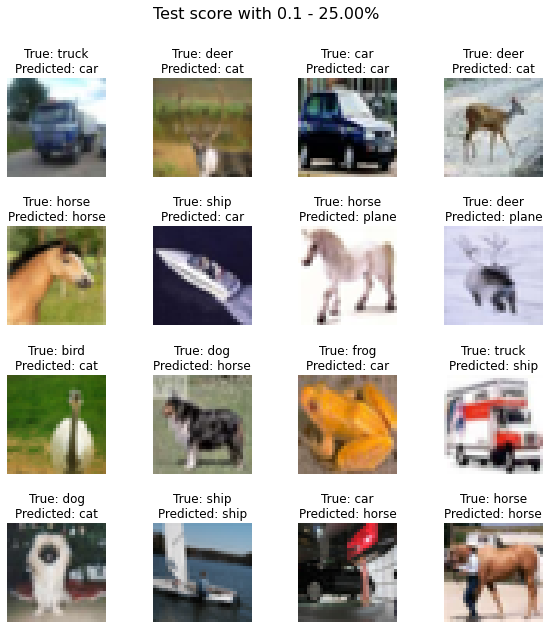

In [78]:
EPOCHS = 4
SUBSET_PROP = 0.10
trainset_subsample, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])
trainloader_subsample = DataLoader(
    trainset_subsample,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
model = ConvNN().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA)
scheduler = None
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss().to(device)
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
accuracy_test = Accuracy(task="multiclass", num_classes=10).to(device)

for epoch in range(EPOCHS):
    # Training
    model.train()
    epoch_loss = 0.0
    for (images, labels) in (pbar := tqdm(trainloader_subsample, desc=f"Epoch {epoch: >5}")) :
        # extract mini batch
        images, labels = images.to(device), labels.to(device)
        batch_size = images.size(0)
        # forward pass
        outputs = model.forward(images)
        label_pred = outputs.argmax(dim=1)
        loss = criterion.forward(outputs, labels)
        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()
        
        # update metrics
        epoch_loss += loss.item()*batch_size/len(trainloader)
        current_lr = optimizer.param_groups[0]['lr']
        train_accuracy = accuracy(labels.cpu(), label_pred.cpu())
        # print statistics
        pbar.set_postfix(
            {
                "train_loss": f"{loss.item():.2f}",
                "train_epoch_loss": f"{epoch_loss:.2f}",
                "train_accuracy": f"{train_accuracy:.2f}",
                "lr": f"{current_lr:.3f}",
            }
        )
    if scheduler is not None:
        scheduler.step()

    # Validation
    with torch.no_grad():
        model.eval()
        test_epoch_loss = 0.0
        for (images_test, label_test) in (pbar := tqdm(testloader, desc=f"Epoch test {epoch: >1}")):
            images_test, label_test = images_test.to(device), label_test.to(device)
            outputs_val = model.forward(images_test)
            label_pred_test = outputs_val.argmax(dim=1)
            loss_test = criterion.forward(outputs_val, label_test)
            test_epoch_loss += loss_test.item()*images_test.size(0)/len(testloader)
            test_accuracy = accuracy_test(label_test.cpu(), label_pred_test.cpu())
            pbar.set_postfix(
                {
                    "test_loss": f"{loss_test.item():.2f}",
                    "test_epoch_loss": f"{test_epoch_loss:.2f}",
                    "test_accuracy": f"{test_accuracy:.2f}",
                }
            )


test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

print(f"Test score with {SUBSET_PROP}: {test_accuracy}")

fig2 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with {SUBSET_PROP} - {test_accuracy*100:.2f}%")
fig2.savefig(f"./figures/test_score_{SUBSET_PROP}.png")

Epoch test 3: 100%|██████████| 157/157 [00:00<00:00, 221.89it/s, test_loss=2.28, test_epoch_loss=146.74, test_accuracy=0.19]


Test score with 0.05: 0.1875


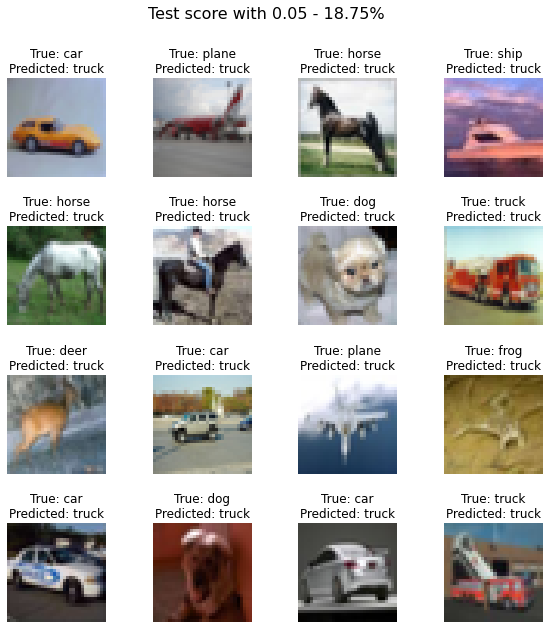

In [79]:
EPOCHS = 4
SUBSET_PROP = 0.05
trainset_subsample, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])
trainloader_subsample = DataLoader(
    trainset_subsample,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
model = ConvNN().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA)
scheduler = None
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss().to(device)
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
accuracy_test = Accuracy(task="multiclass", num_classes=10).to(device)

for epoch in range(EPOCHS):
    # Training
    model.train()
    epoch_loss = 0.0
    for (images, labels) in (pbar := tqdm(trainloader_subsample, desc=f"Epoch {epoch: >5}")) :
        # extract mini batch
        images, labels = images.to(device), labels.to(device)
        batch_size = images.size(0)
        # forward pass
        outputs = model.forward(images)
        label_pred = outputs.argmax(dim=1)
        loss = criterion.forward(outputs, labels)
        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()
        
        # update metrics
        epoch_loss += loss.item()*batch_size/len(trainloader)
        current_lr = optimizer.param_groups[0]['lr']
        train_accuracy = accuracy(labels.cpu(), label_pred.cpu())
        # print statistics
        pbar.set_postfix(
            {
                "train_loss": f"{loss.item():.2f}",
                "train_epoch_loss": f"{epoch_loss:.2f}",
                "train_accuracy": f"{train_accuracy:.2f}",
                "lr": f"{current_lr:.3f}",
            }
        )
    if scheduler is not None:
        scheduler.step()

    # Validation
    with torch.no_grad():
        model.eval()
        test_epoch_loss = 0.0
        for (images_test, label_test) in (pbar := tqdm(testloader, desc=f"Epoch test {epoch: >1}")):
            images_test, label_test = images_test.to(device), label_test.to(device)
            outputs_val = model.forward(images_test)
            label_pred_test = outputs_val.argmax(dim=1)
            loss_test = criterion.forward(outputs_val, label_test)
            test_epoch_loss += loss_test.item()*images_test.size(0)/len(testloader)
            test_accuracy = accuracy_test(label_test.cpu(), label_pred_test.cpu())
            pbar.set_postfix(
                {
                    "test_loss": f"{loss_test.item():.2f}",
                    "test_epoch_loss": f"{test_epoch_loss:.2f}",
                    "test_accuracy": f"{test_accuracy:.2f}",
                }
            )


test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

print(f"Test score with {SUBSET_PROP}: {test_accuracy}")

fig3 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with {SUBSET_PROP} - {test_accuracy*100:.2f}%")
fig3.savefig(f"./figures/test_score_{SUBSET_PROP}.png")

Epoch test 3: 100%|██████████| 157/157 [00:00<00:00, 232.92it/s, test_loss=2.30, test_epoch_loss=146.70, test_accuracy=0.12]


Test score with 0.01: 0.125


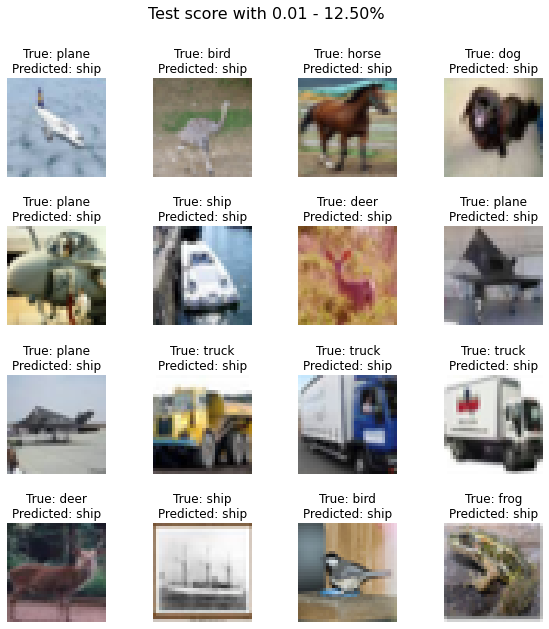

In [80]:
EPOCHS = 4
SUBSET_PROP = 0.01
trainset_subsample, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])
trainloader_subsample = DataLoader(
    trainset_subsample,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
model = ConvNN().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA)
scheduler = None
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss().to(device)
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
accuracy_test = Accuracy(task="multiclass", num_classes=10).to(device)

for epoch in range(EPOCHS):
    # Training
    model.train()
    epoch_loss = 0.0
    for (images, labels) in (pbar := tqdm(trainloader_subsample, desc=f"Epoch {epoch: >5}")) :
        # extract mini batch
        images, labels = images.to(device), labels.to(device)
        batch_size = images.size(0)
        # forward pass
        outputs = model.forward(images)
        label_pred = outputs.argmax(dim=1)
        loss = criterion.forward(outputs, labels)
        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()
        
        # update metrics
        epoch_loss += loss.item()*batch_size/len(trainloader)
        current_lr = optimizer.param_groups[0]['lr']
        train_accuracy = accuracy(labels.cpu(), label_pred.cpu())
        # print statistics
        pbar.set_postfix(
            {
                "train_loss": f"{loss.item():.2f}",
                "train_epoch_loss": f"{epoch_loss:.2f}",
                "train_accuracy": f"{train_accuracy:.2f}",
                "lr": f"{current_lr:.3f}",
            }
        )
    if scheduler is not None:
        scheduler.step()

    # Validation
    with torch.no_grad():
        model.eval()
        test_epoch_loss = 0.0
        for (images_test, label_test) in (pbar := tqdm(testloader, desc=f"Epoch test {epoch: >1}")):
            images_test, label_test = images_test.to(device), label_test.to(device)
            outputs_val = model.forward(images_test)
            label_pred_test = outputs_val.argmax(dim=1)
            loss_test = criterion.forward(outputs_val, label_test)
            test_epoch_loss += loss_test.item()*images_test.size(0)/len(testloader)
            test_accuracy = accuracy_test(label_test.cpu(), label_pred_test.cpu())
            pbar.set_postfix(
                {
                    "test_loss": f"{loss_test.item():.2f}",
                    "test_epoch_loss": f"{test_epoch_loss:.2f}",
                    "test_accuracy": f"{test_accuracy:.2f}",
                }
            )


test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

print(f"Test score with {SUBSET_PROP}: {test_accuracy}")

fig4 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with {SUBSET_PROP} - {test_accuracy*100:.2f}%")
fig4.savefig(f"./figures/test_score_{SUBSET_PROP}.png")

## FixMatch

In [86]:
EPOCHS = 10

# Model
model = ConvNN().to(device)

# Criterion
supervised_criterion = nn.CrossEntropyLoss().to(device)
unsupervised_criterion = nn.CrossEntropyLoss().to(device)

# Metrics
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)

# Optimizer & Scheduler
optimizer = torch.optim.AdamW(model.parameters())

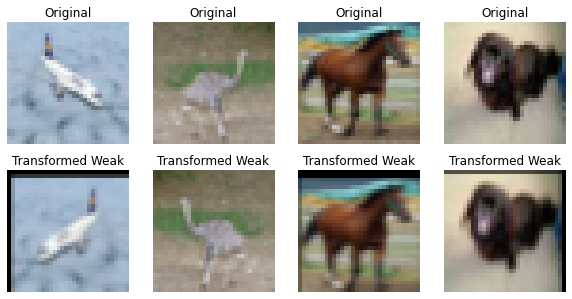

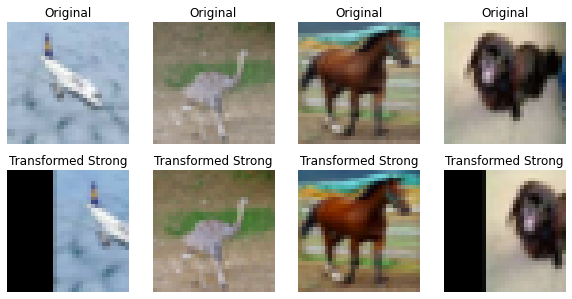

In [87]:
# Transform
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), # 50% chance of flipping
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)), # 12.5% chance of vertical of horizontal translation
)

strong_transform = K.ImageSequential(
    K.auto.AutoAugment("cifar10"),
    # K.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
)

fig5 = plot_transform(test_image, weak_transform, "Weak")
fig6 = plot_transform(test_image, strong_transform, "Strong")

fig5.savefig(f"./figures/weak_transform.png")
fig6.savefig(f"./figures/strong_transform.png")

In [88]:
# Split trainset into train and validation
trainset_sup, trainset_unsup = torch.utils.data.random_split(trainset, [1/(1+MU), MU/(1+MU)])

trainloader_sup = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
trainloader_unsup = DataLoader(
    trainset_unsup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

In [89]:
# Training loop
for epoch in range(EPOCHS):
    # Training
    model.train()
    epoch_loss = 0.0
    trainloader_sup_iter = iter(trainloader_sup)

    for batch_idx in (pbar := tqdm(range(len(trainloader_sup)), desc=f"Epoch {epoch: >5}")):
        # extract mini batch
        images_sup, labels_sup = trainloader_sup_iter.__next__()
        images_sup, labels_sup = images_sup.to(device), labels_sup.to(device)
        
        # Supervised part
        with torch.no_grad():
            images_sup_weak = weak_transform(images_sup)
        logits_weak_pred_sup = model.forward(images_sup_weak)
        proba_weak_pred_sup = torch.nn.functional.softmax(logits_weak_pred_sup, dim=1)
        label_weak_pred_sup = proba_weak_pred_sup.argmax(dim=1)
        loss_weak_sup = supervised_criterion.forward(logits_weak_pred_sup, labels_sup)

        # Unsupervised part
        trainloader_unsup_iter = iter(trainloader_unsup)
        loss_strong_unsup = torch.tensor([0.0], device=device)
        for b_batch_idx in range(MU):
            images_unsup, _ = trainloader_unsup_iter.__next__()
            images_unsup = images_unsup.to(device)

            with torch.no_grad():
                image_unsup_weak = weak_transform(images_unsup)
            logits_weak_pred_unsup = model.forward(image_unsup_weak)
            proba_weak_pred_unsup = torch.nn.functional.softmax(logits_weak_pred_unsup, dim=1)
            label_weak_pred_unsup = proba_weak_pred_unsup.argmax(dim=1)
            confidence_mask = proba_weak_pred_unsup.max(dim=1)[0] > TAU

            if len(confidence_mask) != 0:
                with torch.no_grad():
                    image_unsup_strong = strong_transform(images_unsup)
                logits_strong_pred_unsup = model.forward(image_unsup_strong)
                proba_strong_pred_unsup = torch.nn.functional.softmax(logits_strong_pred_unsup, dim=1)
                label_strong_pred_unsup = proba_strong_pred_unsup.argmax(dim=1)

                loss_strong_unsup_ = unsupervised_criterion.forward(logits_strong_pred_unsup[confidence_mask], label_weak_pred_unsup[confidence_mask])#*(len(confidence_mask)/images_unsup.size(0))
                loss_strong_unsup  = loss_strong_unsup + loss_strong_unsup_

        # Total loss
        loss = loss_weak_sup + LAMBDA_U*loss_strong_unsup

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()

        # update metrics
        epoch_loss += loss.item()*(images_sup.size(0) + images_unsup.size(0))/(len(trainset_sup) + LAMBDA_U*len(trainset_unsup))
        # print statistics
        pbar.set_postfix(
            {
                "train_loss_sup": f"{loss_weak_sup.item():.5f}",
                "confident": f"{confidence_mask.sum().item()}",
                "train_loss_unsup": f"{loss_strong_unsup.item():.5f}",
                "train_loss_total": f"{loss.item():.5f}",
                "epoch_loss": f"{epoch_loss:.5f}",
                "lr": f"{optimizer.param_groups[0]['lr']:.3f}",
            }
        )
    if scheduler is not None:
        scheduler.step()

    # Validation
    with torch.no_grad():
        model.eval()
        test_epoch_loss = 0.0
        for (images_test, label_test) in (pbar := tqdm(testloader, desc=f"Epoch val {epoch: >1}")):
            images_test, label_test = images_test.to(device), label_test.to(device)
            outputs_test = model.forward(images_test)
            label_pred_test = outputs_test.argmax(dim=1)
            loss_val = supervised_criterion.forward(outputs_test, label_test)
            test_epoch_loss += loss_val.item()*images_test.size(0)/len(testloader)
            pbar.set_postfix(
                {
                    "test_loss": f"{loss_val.item():.2f}",
                    "test_epoch_loss": f"{test_epoch_loss:.2f}",
                    "test_accuracy": f"{accuracy(label_test.cpu(), label_pred_test.cpu()):.2f}",
                }
            )
        

Epoch val 9: 100%|██████████| 157/157 [00:00<00:00, 230.61it/s, test_loss=2.47, test_epoch_loss=157.68, test_accuracy=0.31]


In [20]:
test_image, test_labels = testLoader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

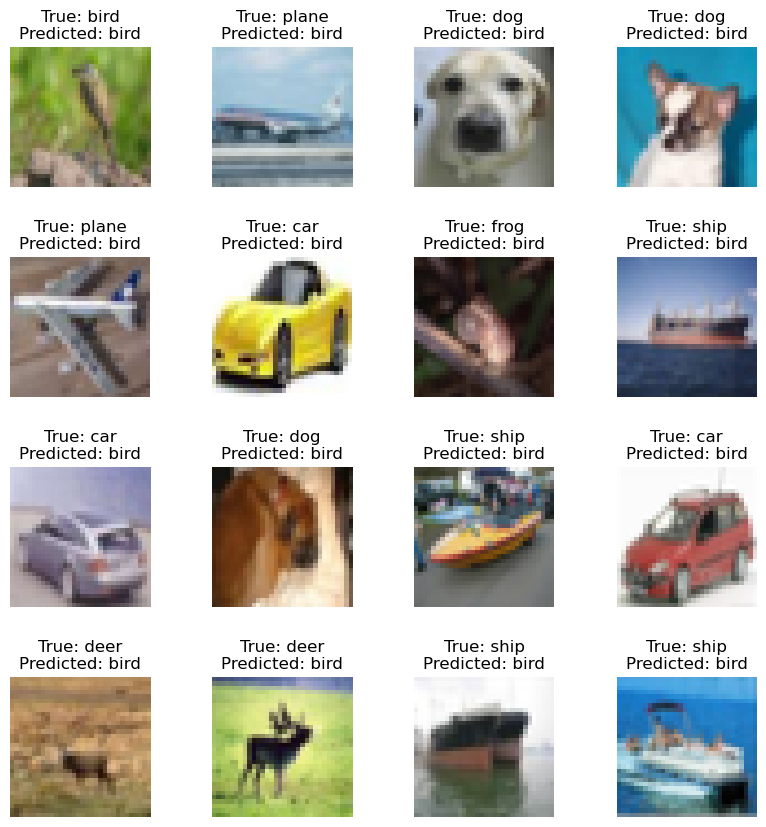

In [21]:
fig1 = plot_images(images=test_image, true_labels=test_labels, predicted_labels=label_pred_test, classes=dataset.classes)